# Classifying Radiohead lyrics with super vector distribution

## Motivation

I wrote my thesis this semester related to LLM-agents and it included a research on the topic of NLP. I found especially interesting the discoveries of Mikolov et al. ([Mikolov et al. 2013](https://arxiv.org/abs/1301.3781)) about word embeddings and interesting relationships between them. Their work showcased that we can represent semantic meanings of words precisely in finite dimensions and many question have come to my mind:

- What if we use the words' semantic representations for **unsupervised clustering**?
- What are the **words represented by a cluster**? Do they represent easiliy interpretable connections?
- Can we use these clusters for **document classifying**?

I decided that I will dvelve more deeply on the topic and try to answer these questions on the corpus of the radiohead lyrics.

During the research for this project, I found a method by Butnaru et al. ([Butnaru et al. 2017](https://sciencedirect.com/science/article/pii/S1877050917316071)) where they implemented **k-means clustering** to create ***super word vectors*** and then classified documents based on the distribution of super word vectors in each document. Their algorithm is similar to what I initially planned to do so I decided to follow the same logic, but I will try a **hierarhichal clustering** algorithm, and I will also use **dimension reduction** based on the corpus to see wether it helps the quality of the clustering. For the classification part my documents are going to be radiohead song lyrics and each album will be one class.

The main goal of the research is to experience with some of the learned techniques of a Data Science course I took at the University and to satisfy my curiosity. I am aware that using word embeddings isn't the most preferable approach for document classification and it would be more logical to use text embedding models on longer text chunks. This solution on the other hand doesn't require the high computing power of such models and can be trained on relatively shorter document sets.


#### Hypothesis

**We can classify songs based on the distribution of their *Super Vectors***

In [453]:
%load_ext autoreload

%autoreload 2

In [553]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from barchart import bar_charts3d_from_array  # source: https://github.com/AymericFerreira/Plotly_barchart3D, I had to modify the file because it contained a bug
from sklearn import svm
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.datasets as skdata
import sklearn.model_selection as skmodel
import sklearn.tree as sktree
import sklearn.metrics as skmetrics
import sklearn.naive_bayes as sknb
import sklearn.neighbors as skneigh
import sklearn.ensemble as skensamble
import sklearn.neighbors as skneigh
import sklearn.model_selection as skmodel
import sklearn.linear_model as sklinear
from openai import AzureOpenAI
import os
import json
from dotenv import load_dotenv
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

In [455]:
load_dotenv()

True

In [456]:
with open(Path('data/embeddings.csv')) as f:
    embeddings = pd.read_csv(f, index_col=0)

with open(Path('data/radiohead_extended.csv')) as f:
    radiohead = pd.read_csv(f)

In [457]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lock,0.017944,0.193359,-0.062988,0.024292,0.001579,0.075195,-0.057129,0.139648,0.269531,0.027710,...,0.039062,0.277344,0.102539,0.100586,-0.030518,-0.144531,-0.123047,-0.218750,-0.049561,0.026978
path,0.083496,0.138672,0.005829,0.213867,0.024902,-0.131836,0.121094,-0.412109,-0.236328,0.349609,...,-0.062988,0.154297,-0.226562,0.055420,0.047363,-0.046875,0.109863,0.036865,0.032471,0.019897
microwave,-0.300781,-0.066895,0.075684,0.324219,-0.030762,0.013245,0.172852,-0.328125,0.022461,0.239258,...,-0.103027,-0.019165,-0.410156,0.214844,-0.012451,-0.515625,-0.011963,0.007416,-0.075684,0.219727
dealers,0.135742,0.170898,-0.042969,0.298828,-0.008240,0.053955,-0.033447,0.085938,-0.041016,0.314453,...,0.049561,0.167969,-0.177734,-0.062500,0.335938,0.104492,-0.144531,0.107422,0.152344,-0.660156
bouncing,-0.180664,0.110840,-0.104004,0.125977,-0.053955,-0.234375,-0.187500,0.202148,0.154297,0.289062,...,-0.271484,0.175781,0.032227,-0.136719,0.201172,0.081543,0.240234,-0.130859,0.067383,-0.025024


In [458]:
embeddings_vector = np.array(embeddings)
print(embeddings_vector.shape)
print(embeddings_vector.dtype)

(1755, 300)
float64


## Clustering using original embeddings

In [459]:
# I will try different linkage methods to find a cluster number and linkage method that fits the data representation
model_average = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances = True,  # We want to determine the clusters based on the distances
                                metric="cosine",  # They usually use cosine for text embeddings and it is not as computational heavy
                                linkage="average")  # I use the average values for each cluster to determine the distances
model_average.fit(embeddings_vector)

model_min = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances = True,
                                metric="cosine",
                                linkage="single")
model_min.fit(embeddings_vector)

model_max = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances = True,
                                metric="cosine",
                                linkage="complete")
model_max.fit(embeddings_vector)

AgglomerativeClustering(compute_distances=True, distance_threshold=0,
                        linkage='complete', metric='cosine', n_clusters=None)

In [460]:
model_average.labels_

array([1529, 1441, 1559, ...,    1,    2,    0])

In [461]:
def plot_dendrogram(model, n_clusters, **kwargs):
    # Create linkage matrix
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Calculate the color threshold to get the desired number of clusters
    distances = linkage_matrix[:, 2]  # Distances of merges
    if n_clusters > 1:
        # Find the threshold just below the merge that results in n_clusters
        threshold = sorted(distances, reverse=True)[n_clusters - 2]
    else:
        threshold = max(distances) + 1  # Single cluster case

    # Plot dendrogram with colors
    dendrogram(linkage_matrix, color_threshold=threshold, **kwargs)

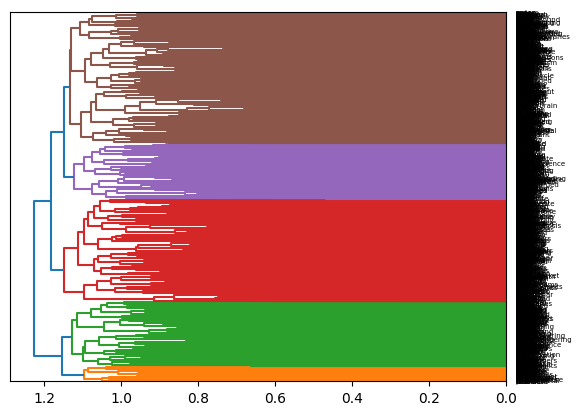

In [8]:
# Bit messy for 1750 words
plot_dendrogram(model_max, n_clusters=5, truncate_mode="level", labels = embeddings.index, orientation = 'left')

In [462]:
# I would like to find a cluster number that fits the dataset most, try to use the 'elbow method'
# I will only use the top 50 distances for illustration as using all of the dimensions wasn't revealing
distances = {
    'average': sorted(model_average.distances_)[-50:],
    'single': sorted(model_min.distances_)[-50:],
    'complete': sorted(model_max.distances_)[-50:],
}

fig = go.Figure()

# Add all traces to the same plot
fig.add_trace(
    go.Scatter(y=distances['average'], mode='lines', name='Average Linkage')
)

fig.add_trace(
    go.Scatter(y=distances['single'], mode='lines', name='Single Linkage')
)

fig.add_trace(
    go.Scatter(y=distances['complete'], mode='lines', name='Complete Linkage')
)

# Update layout
fig.update_layout(
    height=600,
    title_text='Hierarchical Clustering Distances by Linkage Method',
    xaxis_title="Merge Step",
    yaxis_title="Distance",
    showlegend=True
)

fig.show()

Complete linkage at 6 and 14 clusters look the most similar to the elbow form

I think more clusters could be more interesting so I went with complete linkage at 14

In [463]:
n_clusters = 14
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='cosine')
model.fit(embeddings_vector)

AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=14)

In [464]:
embeddings['labels_all_dimension'] = model.labels_

grouped = embeddings[['labels_all_dimension', '0']].groupby('labels_all_dimension').count()

fig = px.bar(grouped, title="Distribution of words by cluster", labels={'value': 'Count', 'labels_all_dimension': 'Cluster'})
fig.update_layout(showlegend=False)
fig.show()

In [465]:
def cosine_similarity(a, b):
    # Compute dot product
    dot_product = np.dot(a, b)
    # Compute norms
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    # Return cosine similarity
    return dot_product / (norm_a * norm_b)

# Calculate distances from each point to the cluster center
cluster_centers = embeddings.groupby('labels_all_dimension').mean()

# Calculate distance to cluster center
embeddings['distance_to_center'] = embeddings.apply(lambda x: cosine_similarity(x.iloc[:-1], cluster_centers.iloc[int(x.iloc[0])]), axis=1)

# Get 10 closest points to their cluster centers
for i in range(n_clusters):
    closest_points = embeddings[embeddings['labels_all_dimension'] == i].nsmallest(10, 'distance_to_center')[['distance_to_center', 'labels_all_dimension']]
    print(f"\nWords closest to cluster center {i}:")
    print(', '.join(closest_points.index))



Words closest to cluster center 0:
produced, calculated, edited, th, st, judged, city, special, twentieth, foul

Words closest to cluster center 1:
cathode, voltage, instruments, system, channels, figures, yen, airbag, women, antibiotics

Words closest to cluster center 2:
morrison, c, ca, chimeras, roman, na, april, german, wo, ha

Words closest to cluster center 3:
myxomatosis, beholder, weakness, triplicate, fats, scaremongering, hens, deaf, opportunist, memory

Words closest to cluster center 4:
sleight, empire, outro, giant, voodoo, footsteps, melody, solo, troubled, guitar

Words closest to cluster center 5:
iron, maths, veins, underground, trapdoors, saturated, yuppies, pulse, immerse, magazine

Words closest to cluster center 6:
k, speakers, wool, employee, empowered, branch, position, pane, economics, strain

Words closest to cluster center 7:
covers, deepest, holds, across, steer, disinfected, bearing, deep, lies, frozen

Words closest to cluster center 8:
purest, films, che

In [466]:
# I named the cluster with an LLM based on the words in the middle
clusters = {
    0: "Communication & Speaking",     # focused on verbal interaction and networking
    1: "Professional Roles & Titles",  # related to organizational positions and roles 
    2: "Time & References",            # contains dates, abbreviations, and reference terms
    3: "Movement & Growth",            # words about motion, development, and physical change
    4: "Goals & Boundaries",           # related to objectives, limits, and reaching targets
    5: "Production & Publishing",      # focused on releasing and crediting content
    6: "Time & Technology",            # mix of temporal and technical/mechanical terms
    7: "Business & Market",            # related to commercial and business activities
    8: "Action & Possession",          # verbs related to taking, giving, and holding
    9: "Business Metrics",             # focused on numbers, sales, and business outcomes
    10: "Family & Mortality",          # personal relationships and life/death themes
    11: "Physical Objects",            # concrete nouns and environmental elements
    12: "Assessment & Quality",        # words related to evaluation and performance
    13: "Creation & Process"           # verbs and nouns related to making and doing
}


In [467]:
# Reduce dimensionality to 3D using PCA for visualization
pca = PCA(n_components=3)
words_3d = pca.fit_transform(embeddings_vector)

# Create dataframe with reduced dimensions
reduced_df = pd.DataFrame(
    words_3d,
    index=embeddings.index,
    columns=[f'PC{i+1}' for i in range(words_3d.shape[1])],
)

# Add cluster labels column
reduced_df['cluster'] = embeddings['labels_all_dimension']

# Create 3D scatter plot
# Sample every 20th point to reduce clutter
# Color points by cluster and show word on hover
px.scatter_3d(reduced_df.iloc[::20,:], x='PC1', y='PC2', z='PC3', 
              color=pd.Categorical(reduced_df.iloc[::20,:]['cluster']),
              hover_name=reduced_df.iloc[::20,:].index,
              labels=list(clusters.values()))

## Calculating super word distribution for lyrics

In [468]:
radiohead.head()  # radiohead head haha

,Unnamed: 0,track_name,valence,duration_ms,lyrics,album_name,album_release_year,album_img,pct_sad,word_count,lyrical_density,gloom_index,tokens
0,0,You,0.305,208667,you are the sun and moon and stars are you and...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0000,19,0.091054,50.39,"['sun', 'moon', 'stars', 'run', 'away', 'worki..."
1,1,Creep,0.096,238640,when you were here before couldn't look you in...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0784,51,0.213711,22.60,"['look', 'eye', 'like', 'angel', 'skin', 'make..."
2,2,How Do You?,0.264,132173,he's bitter and twisted he knows what he wants...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0952,21,0.158883,36.56,"['bitter', 'twisted', 'knows', 'wants', 'wants..."
3,3,Stop Whispering,0.279,325627,and the wise man said i don't want to hear you...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0435,46,0.141266,43.48,"['wise', 'man', 'said', 'want', 'hear', 'voice..."
4,4,Thinking About You,0.419,161533,been thinking about you your records are here ...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0000,39,0.241437,60.80,"['thinking', 'records', 'eyes', 'still', 'one'..."


In [469]:
# Create set of words that have embeddings for faster lookup
words_w_embeddings = set(embeddings.index)

def apply_distrib(row: pd.Series):
    # Initialize array to store frequency counts for each cluster
    frequencies = np.zeros(n_clusters, dtype='int64')

    def calculate_distrib(token: str):
        # If token exists in our embeddings, increment count for its cluster
        if token in words_w_embeddings:
            frequencies[(embeddings.loc[token, 'labels_all_dimension'])] += 1

    # For each token in the row's token list, calculate its distribution
    for token in eval(row['tokens']):
        calculate_distrib(token)

    return frequencies

# Stack the distributions for each row into a 2D array
# Using pandas apply instead of loop for better performance
distributions = np.vstack(radiohead.apply(apply_distrib, axis=1))

In [470]:
distributions.dtype

dtype('int64')

In [471]:
column_names = list(clusters.values())
radiohead[column_names] = distributions
radiohead.head().loc[:,column_names[0]:]  # radiohead head haha

,Communication & Speaking,Professional Roles & Titles,Time & References,Movement & Growth,Goals & Boundaries,Production & Publishing,Time & Technology,Business & Market,Action & Possession,Business Metrics,Family & Mortality,Physical Objects,Assessment & Quality,Creation & Process
0,6,2,2,2,0,3,1,3,2,0,0,1,1,4
1,6,4,1,3,4,3,1,15,10,0,3,1,10,0
2,1,2,3,1,1,0,2,2,11,0,1,2,5,1
3,7,3,4,5,12,0,1,2,13,6,3,0,6,2
4,5,11,0,3,3,2,1,2,5,2,0,5,13,1


In [473]:
bar_columns = column_names + ['album_name']
means = radiohead[bar_columns].groupby('album_name').mean()
bar_values = np.array(means)

x = means.index
y = means.columns
z = bar_values.ravel(order='F')

bar_charts3d_from_array(x, y, z,
                        x_legend=list(x),
                        y_legend=list(means.columns),
                        x_title='Albums',
                        y_title='Clusters',
                        title="Super Vector Histograms mean values for each album")

The Super Vector Histograms don't reveal relevant differences at first glimpse. 

## Classifying based on histograms

In [474]:
# Get features (X) from the histogram columns and album names
X = radiohead[bar_columns]

# Initialize label encoder to convert album names to numeric values
le = LabelEncoder()

# Encode album names as numeric labels
y = le.fit_transform(X['album_name'])

# Remove album_name column from features since it's now encoded in y
X = X.drop('album_name', axis=1)

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I don't expect very high correlations between the Super Vector Histograms and the album years so the model choice is relevant to maximize the result. The idea is that songs in the same album will have similar Super Vector distribution, so some of model choices that come to mind: kNN, Decision Tree, Some sort of Linear Regression.

### kNN

In [475]:
def kNNResults(k_max):
    # Iterate through k values from 1 to k_max
    for k in range(1,k_max+1):
        # Create kNN classifier with current k value
        kNN = skneigh.KNeighborsClassifier(k)
        # Create cross validation object with 4 splits and 3 repeats
        cv = skmodel.RepeatedStratifiedKFold(n_splits=4, n_repeats=3)
        # Get mean accuracy score using cross validation
        res = skmodel.cross_val_score(kNN,X_train,y_train,scoring='accuracy',cv=cv).mean()
        # Yield tuple of k value and accuracy score
        yield k,res

In [476]:
kNN_result = dict(kNNResults(20))

In [477]:
kNN_result

{1: 0.09364035087719297,
 2: 0.08947368421052632,
 3: 0.09824561403508773,
 4: 0.12785087719298247,
 5: 0.11206140350877192,
 6: 0.15372807017543857,
 7: 0.11578947368421051,
 8: 0.09364035087719298,
 9: 0.09758771929824561,
 10: 0.11096491228070172,
 11: 0.1287280701754386,
 12: 0.12741228070175437,
 13: 0.1149122807017544,
 14: 0.14057017543859648,
 15: 0.11557017543859649,
 16: 0.11951754385964913,
 17: 0.11162280701754386,
 18: 0.12807017543859647,
 19: 0.09802631578947367,
 20: 0.1151315789473684}

In [478]:
# Tracks at each album
song_count = radiohead[['album_name', 'track_name']].groupby('album_name').count()

px.bar(song_count, title='Tracks at each album')

In [479]:
all_tracks = song_count['track_name'].sum()
max_tracks = song_count['track_name'].max()

greedy_prob = max_tracks / all_tracks
greedy_prob

0.14285714285714285

Best value is at k = 12 and it is only around 17 % accuracy. With the greedy method of assigning 'Hail to the Thief' to every value we get 14,2 % accuracy, so we couldn't improve on the performance too much with kNNeighbours (there are lot of floating point operations so these numbers might vary)

### Decision Tree

In [480]:
tree = sktree.DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [481]:
print(sktree.export_text(tree,feature_names=X_train.columns.tolist()))

|--- Goals & Boundaries <= 0.50
|   |--- Physical Objects <= 1.00
|   |   |--- Time & References <= 0.50
|   |   |   |--- class: 4
|   |   |--- Time & References >  0.50
|   |   |   |--- Communication & Speaking <= 13.50
|   |   |   |   |--- class: 8
|   |   |   |--- Communication & Speaking >  13.50
|   |   |   |   |--- class: 1
|   |--- Physical Objects >  1.00
|   |   |--- Action & Possession <= 0.50
|   |   |   |--- class: 3
|   |   |--- Action & Possession >  0.50
|   |   |   |--- class: 0
|--- Goals & Boundaries >  0.50
|   |--- Assessment & Quality <= 10.50
|   |   |--- Assessment & Quality <= 9.50
|   |   |   |--- Creation & Process <= 3.00
|   |   |   |   |--- Assessment & Quality <= 4.50
|   |   |   |   |   |--- Physical Objects <= 2.50
|   |   |   |   |   |   |--- Business & Market <= 6.50
|   |   |   |   |   |   |   |--- Physical Objects <= 1.50
|   |   |   |   |   |   |   |   |--- Communication & Speaking <= 4.50
|   |   |   |   |   |   |   |   |   |--- Time & References <

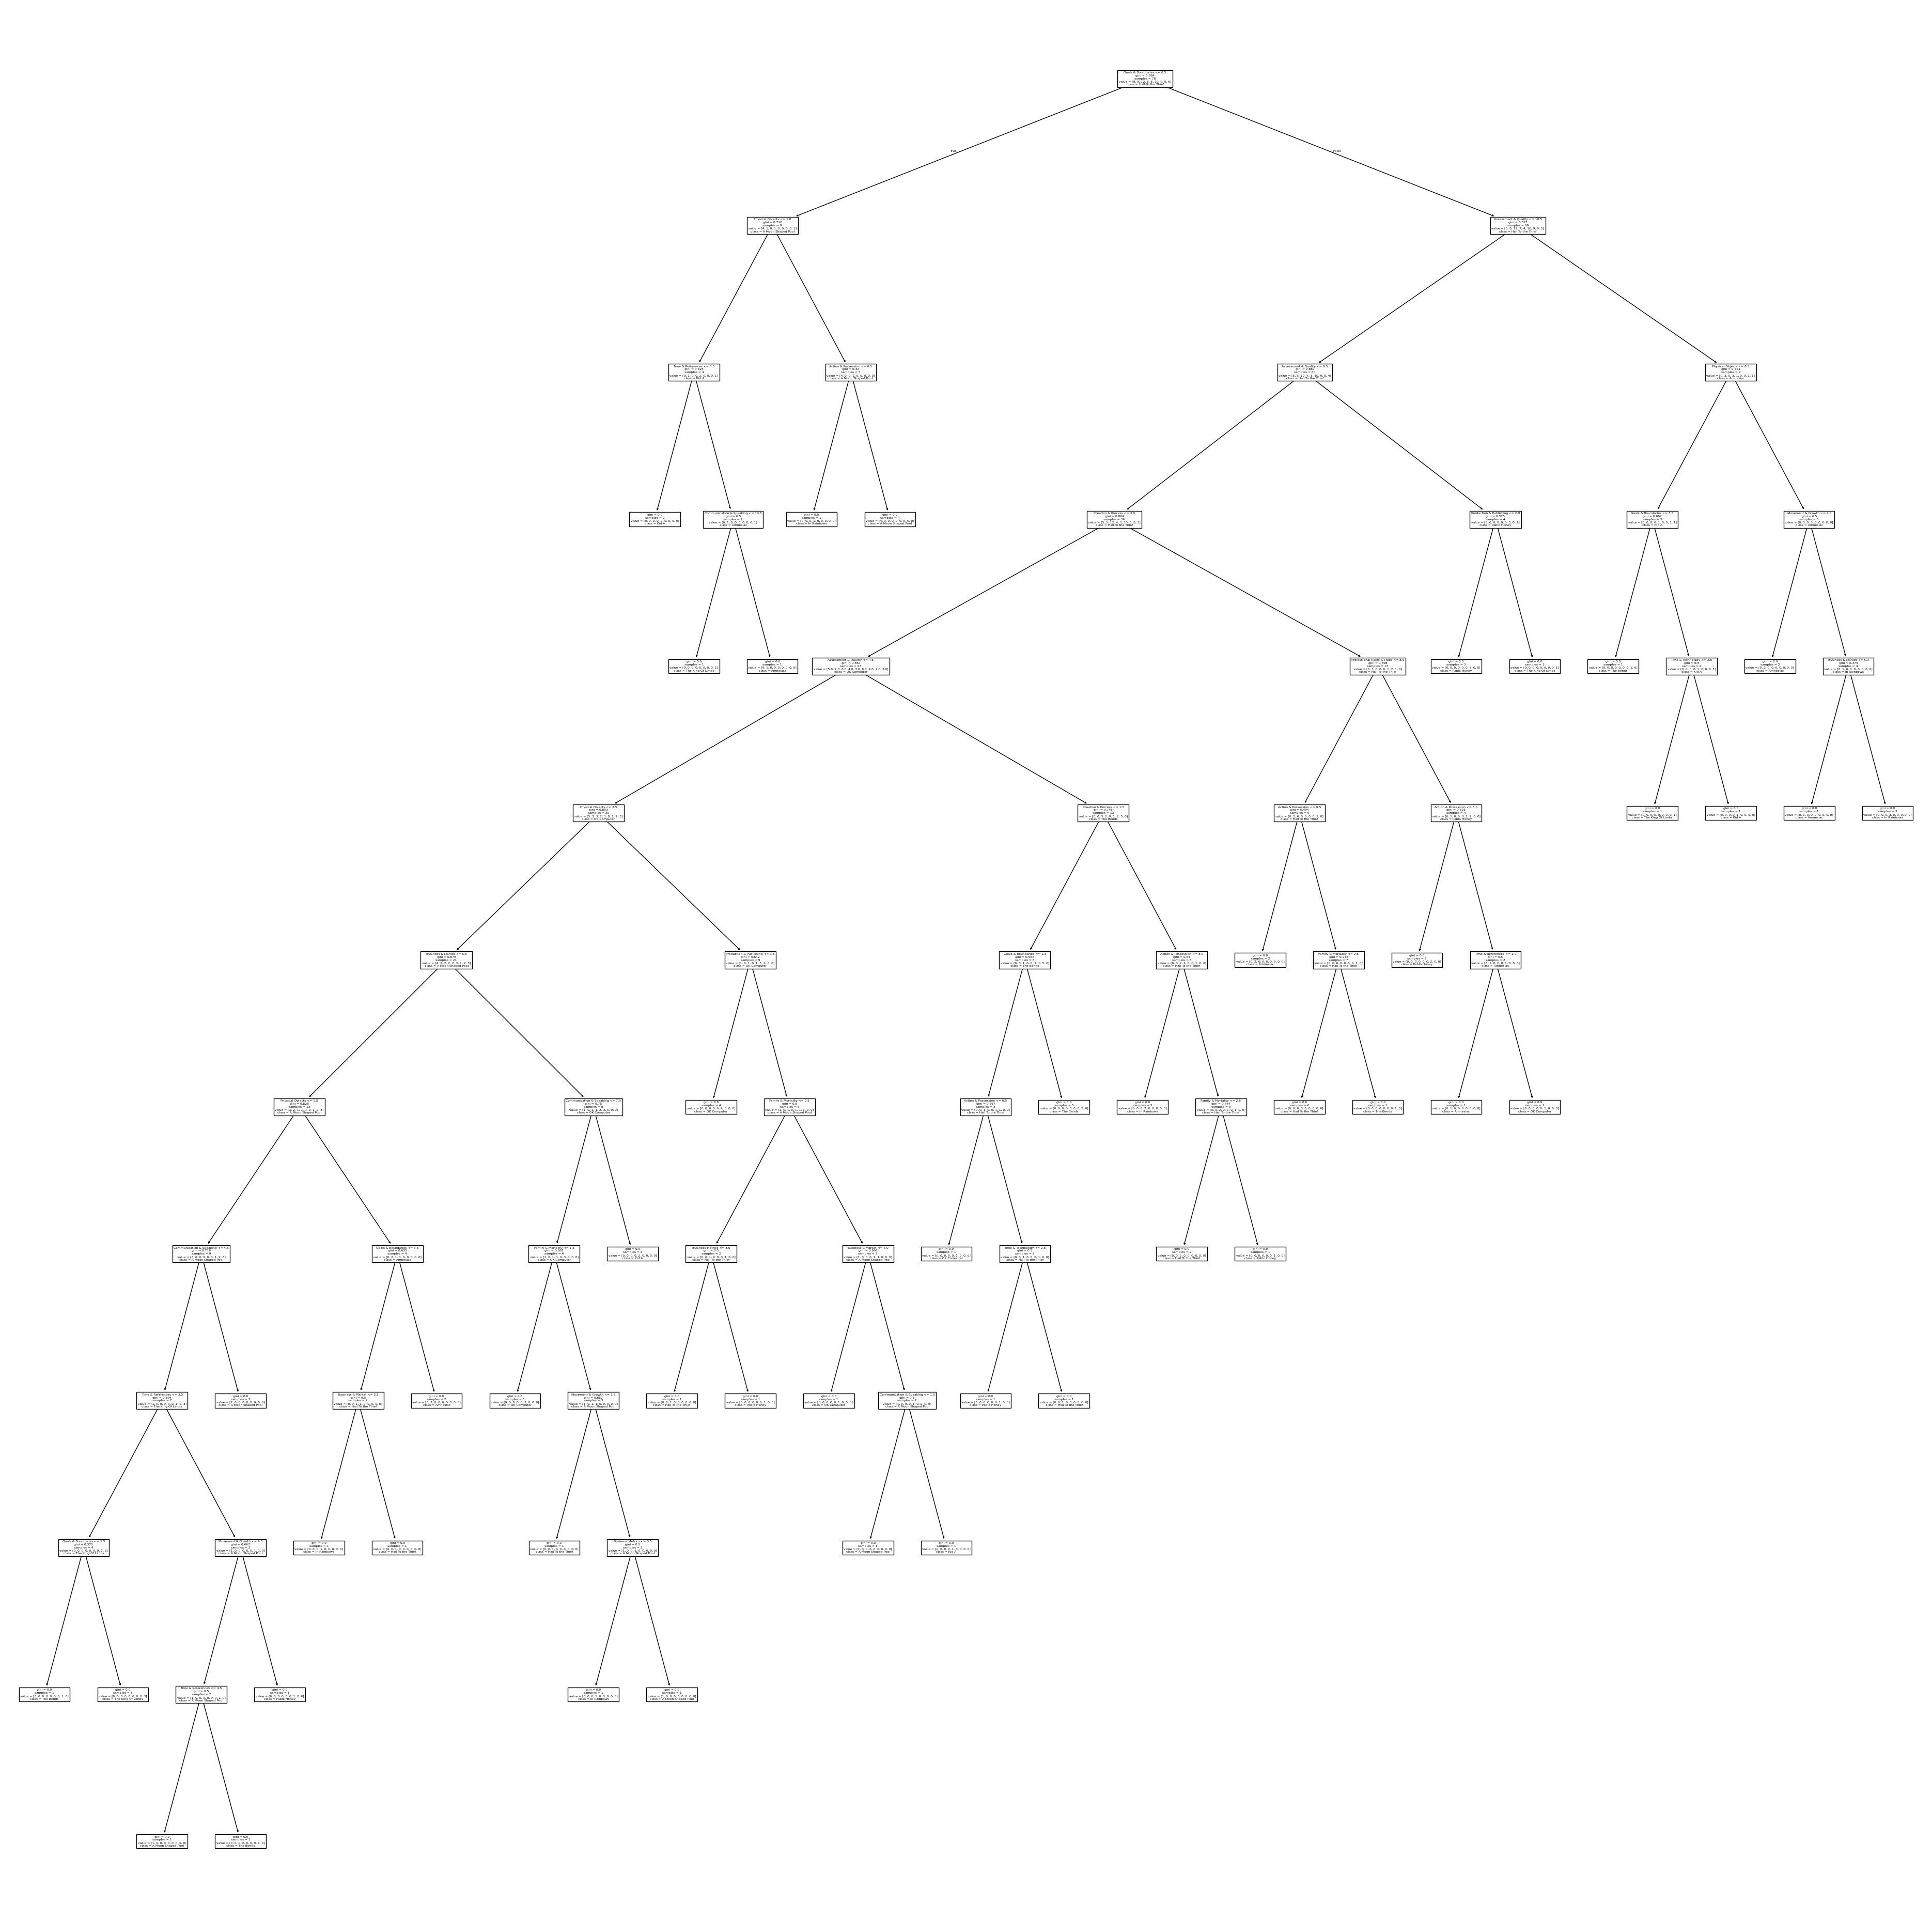

In [482]:
plt.figure(figsize=(48,48))
sktree.plot_tree(tree,
                 feature_names = X_train.columns,
                 class_names = le.classes_);

I had to export the image and zoom in to read the classes and number of samples at each node and leaf.

In [483]:
y_pred = tree.predict(X_train)
y_pred

array([1, 3, 2, 7, 4, 5, 6, 8, 6, 2, 0, 5, 5, 0, 6, 1, 3, 5, 7, 3, 5, 6,
       2, 5, 7, 8, 5, 1, 7, 5, 6, 7, 4, 6, 3, 6, 3, 4, 8, 2, 0, 1, 4, 1,
       2, 1, 2, 2, 0, 3, 4, 2, 1, 8, 2, 5, 0, 2, 2, 0, 4, 5, 6, 1, 7, 6,
       7, 0, 0, 3, 8, 8, 7, 2, 3, 7, 0, 1])

In [484]:
confusion_matrix = skmetrics.confusion_matrix(y_train,y_pred)
confusion_matrix

array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6]])

In [485]:
y_pred = tree.predict(X_test)
y_pred
confusion_matrix = skmetrics.confusion_matrix(y_test,y_pred)
# It seems that the decision tree is quite overfitted on the training set for the full length
confusion_matrix

array([[0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 2, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0]])

In [486]:
for depth in range(1,tree.get_depth()):
    tree = sktree.DecisionTreeClassifier(max_depth = depth)
    scores = skmodel.cross_val_score(tree,X_train,y_train,scoring='accuracy',cv=4) # stratified!
    print(f"Depth: {depth}, mean accuracy: {scores.mean()}")

Depth: 1, mean accuracy: 0.16710526315789473
Depth: 2, mean accuracy: 0.11513157894736842
Depth: 3, mean accuracy: 0.14078947368421052
Depth: 4, mean accuracy: 0.14078947368421052
Depth: 5, mean accuracy: 0.15592105263157896
Depth: 6, mean accuracy: 0.11578947368421053
Depth: 7, mean accuracy: 0.1282894736842105
Depth: 8, mean accuracy: 0.18026315789473685
Depth: 9, mean accuracy: 0.12763157894736843
Depth: 10, mean accuracy: 0.15460526315789475
Depth: 11, mean accuracy: 0.1282894736842105


Still no relevant relationships.

### RandomForestClassifier

In [487]:
rf = skensamble.RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10)

In [488]:
y_pred = rf.predict(X_train)
skmetrics.confusion_matrix(y_train,y_pred)

array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  5,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6]])

In [489]:
max_depth = max(tree.get_depth() for tree in rf.estimators_)

for depth in range(1,max_depth):
    rf_iter = skensamble.RandomForestClassifier(n_estimators=10, max_depth = depth)
    scores = skmodel.cross_val_score(rf_iter,X_train,y_train,scoring='accuracy',cv=4) # stratified!
    print(f"Depth: {depth}, mean accuracy: {scores.mean()}")

Depth: 1, mean accuracy: 0.15592105263157896
Depth: 2, mean accuracy: 0.10131578947368422
Depth: 3, mean accuracy: 0.16710526315789476
Depth: 4, mean accuracy: 0.1282894736842105
Depth: 5, mean accuracy: 0.12894736842105264
Depth: 6, mean accuracy: 0.19210526315789472
Depth: 7, mean accuracy: 0.07631578947368421
Depth: 8, mean accuracy: 0.16381578947368422
Depth: 9, mean accuracy: 0.14144736842105263
Depth: 10, mean accuracy: 0.10328947368421053


### Naiv Bayes

In [490]:
nb = sknb.GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [491]:
y_pred = nb.predict(X_train)
confusion_matrix = skmetrics.confusion_matrix(y_train,y_pred)
confusion_matrix

array([[3, 0, 1, 1, 1, 2, 0, 1, 0],
       [0, 2, 1, 2, 2, 0, 2, 0, 0],
       [0, 1, 4, 1, 1, 2, 3, 0, 0],
       [0, 1, 0, 2, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 4, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 8, 0, 1, 1],
       [0, 0, 0, 1, 2, 2, 3, 0, 1],
       [0, 0, 0, 0, 1, 2, 2, 4, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 5]])

In [492]:
nb = sknb.GaussianNB()
skmodel.cross_val_score(nb,X_train,y_train,scoring='accuracy',cv=4).mean()

0.07828947368421052

In [493]:
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

print(f"{skmetrics.accuracy_score(y_pred=y_pred, y_true=y_test):.4}")
confusion_matrix = skmetrics.confusion_matrix(y_test,y_pred)
confusion_matrix

0.25


array([[0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 2, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0]])

## Creating new classes

The classification trials show that it is really hard to tell the exact album so I rather defined new classes to see if there is some correlation between the word choices and in which decade the strong was written

In [494]:
releases_by_year = radiohead[['album_release_year', 'track_name']].groupby('album_release_year').count()

px.bar(releases_by_year)

In [496]:
# Create binary labels based on whether album was released in 20th or 21st century
radiohead['early_stage'] = np.where(radiohead['album_release_year'] < 2000, 1, 0) # 0 for 20th century, 1 for 21st century

bar_columns = column_names + ['early_stage']
means = radiohead[bar_columns].groupby('early_stage').mean()
bar_values = np.array(means)

x = means.index
y = means.columns
z = bar_values.ravel(order='F')

bar_charts3d_from_array(x, y, z,
                        x_legend=['Late', 'Early'],
                        y_legend=list(means.columns),
                        x_title='Stage',
                        y_title='Clusters',
                        title="Super Vector Histograms mean values early and late stages")

There are no striking differences between the newly created classes neither, but because we have binary values we can measure new features and use new models too

### Hypothesis analysis

In [497]:
column_names = list(clusters.values()) + ['early_stage']
stage_array = radiohead[column_names].groupby('early_stage')
stage_array.count()

,Communication & Speaking,Professional Roles & Titles,Time & References,Movement & Growth,Goals & Boundaries,Production & Publishing,Time & Technology,Business & Market,Action & Possession,Business Metrics,Family & Mortality,Physical Objects,Assessment & Quality,Creation & Process
early_stage,,,,,,,,,,,,,,
0,62,62,62,62,62,62,62,62,62,62,62,62,62,62
1,36,36,36,36,36,36,36,36,36,36,36,36,36,36


In [498]:
# Greedy method accuracy
print(62 / (98))

0.6326530612244898


In [499]:
# ttest
res = stats.ttest_ind(stage_array.get_group(0).drop('early_stage', axis=1), stage_array.get_group(1).drop('early_stage', axis=1))
pd.DataFrame(res, columns=list(clusters.values()),index=["T-stat","p-value"])

,Communication & Speaking,Professional Roles & Titles,Time & References,Movement & Growth,Goals & Boundaries,Production & Publishing,Time & Technology,Business & Market,Action & Possession,Business Metrics,Family & Mortality,Physical Objects,Assessment & Quality,Creation & Process
T-stat,1.010897,-0.049252,0.354887,0.864985,0.279910,0.927871,-0.170225,1.522917,-1.512683,-1.074869,-0.613075,0.518258,-0.598813,0.495166
p-value,0.314607,0.960820,0.723453,0.389203,0.780149,0.355802,0.865192,0.131067,0.133645,0.285128,0.541277,0.605471,0.550708,0.621614


Tipically in t-tests:

if p < 0.05, we reject the null hypothesis of t-test --> there is a difference between the two quantities

if p >> 0.05, we accept the null hypothesis --> the difference between the means of the two sample groups is due to random sampling

therefore there is no statistically significant feature, because all values are over p = 0.15

In [500]:
# correlation between supervectors
px.imshow(radiohead[column_names].corr(),text_auto=True, aspect='auto')

In [501]:
px.imshow((radiohead[column_names].corr()>0.5)/1.0,text_auto=True, aspect='auto')

The correlations are only relevant between Goals & Boundaries and Production & Publishing

### Linear Regression

In [502]:
X = np.array(radiohead[column_names].iloc[:,:-1])
y = np.array(radiohead['early_stage'])

In [503]:
# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [504]:
reg = sklinear.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [505]:
# Data is relatively aligned to the middle
reg.intercept_

0.23945258633972807

In [506]:
reg.coef_

array([-0.02891796,  0.01265975,  0.00059344, -0.0008642 ,  0.01058645,
       -0.00704943,  0.00726563, -0.00966287,  0.02437915,  0.04792178,
        0.01469164, -0.02873027, -0.00124377,  0.00913049])

In [507]:
# Rank is okay, we have 14 dimensions
reg.rank_

14

In [508]:
y_pred = reg.predict(X_test)
accuracy = np.mean((y_pred >= 0.5) == y_test)
accuracy


0.5

Linear regression is not the best choice

### kNN with new classes

In [509]:
accs = np.array(list(kNNResults(20)))[:,1]
max_arg = accs.argmax()
accs[max_arg]

0.6414473684210527

In [510]:
max_depth = max(tree.get_depth() for tree in rf.estimators_)

for depth in range(1,max_depth):
    rf_iter = skensamble.RandomForestClassifier(n_estimators=10, max_depth = depth)
    scores = skmodel.cross_val_score(rf_iter,X_train,y_train,scoring='accuracy',cv=4) # stratified!
    print(f"Depth: {depth}, mean accuracy: {scores.mean()}")

Depth: 1, mean accuracy: 0.6407894736842106
Depth: 2, mean accuracy: 0.6276315789473684
Depth: 3, mean accuracy: 0.5750000000000001
Depth: 4, mean accuracy: 0.5875
Depth: 5, mean accuracy: 0.5243421052631578
Depth: 6, mean accuracy: 0.6789473684210525
Depth: 7, mean accuracy: 0.6032894736842105
Depth: 8, mean accuracy: 0.5993421052631579
Depth: 9, mean accuracy: 0.5493421052631579
Depth: 10, mean accuracy: 0.6421052631578947


71.8 % accuracy suggests that there might be relations between super vectors and  in which stage of the band the track was recorded. The mood change for the album *Kid A* is undeniable regarding sound, but some relationship might be in selection of words too.

Still not really relevant around 8 % better than greedy method.

In [511]:
rf = skensamble.RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10)

In [512]:
y_pred = rf.predict(X_train)
skmetrics.confusion_matrix(y_train,y_pred)

array([[49,  1],
       [ 1, 27]])

In [513]:
max_depth = max(tree.get_depth() for tree in rf.estimators_)

for depth in range(1,max_depth):
    rf_iter = skensamble.RandomForestClassifier(n_estimators=10, max_depth = depth)
    scores = skmodel.cross_val_score(rf_iter,X_train,y_train,scoring='accuracy',cv=4) # stratified!
    print(f"Depth: {depth}, mean accuracy: {scores.mean()}")

Depth: 1, mean accuracy: 0.6539473684210526
Depth: 2, mean accuracy: 0.5763157894736842
Depth: 3, mean accuracy: 0.6401315789473685
Depth: 4, mean accuracy: 0.6651315789473684
Depth: 5, mean accuracy: 0.6664473684210527
Depth: 6, mean accuracy: 0.6263157894736842
Depth: 7, mean accuracy: 0.6901315789473684
Depth: 8, mean accuracy: 0.6414473684210527
Depth: 9, mean accuracy: 0.6394736842105263
Depth: 10, mean accuracy: 0.6138157894736842


## Dimension reduction with PCA

I want to test whether reducing dimension can help the quality of *Super Vectors*. In theory reducing dimension based on the dataset can make calculated similarities more relevant to the dataset. Therefore the clusters will probably be more separated and might be more suitable for classification.

In [514]:
scaler = MinMaxScaler()  # Initialize the MinMaxScaler to scale the embeddings
embeddings_vector = scaler.fit_transform(np.array(embeddings))  # Fit the scaler to the embeddings and transform them
pca = PCA(n_components=0.95)  # Initialize PCA to reduce dimensions while retaining 95% of variance
pca.fit(embeddings_vector)  # Fit PCA on the scaled embeddings
embeddings_reduced_vector = pca.transform(embeddings_vector)  # Transform the scaled embeddings to reduced dimensions
embeddings_reduced_vector.shape[1]

236

We reduced with 64 dimension

In [515]:
# The explained variance ratio indicates the proportion of the dataset's variance that is captured by each principal component.
# It helps to understand how much information (variance) is retained after reducing the dimensionality of the data.
# It is relatively low for each element, which is expected in hundred dimensions
pca.explained_variance_ratio_

array([0.02716252, 0.02503186, 0.02015151, 0.01846673, 0.01668779,
       0.01490659, 0.01445268, 0.01411145, 0.01325156, 0.01232672,
       0.01184174, 0.01160597, 0.01128149, 0.01040436, 0.01034242,
       0.00961571, 0.00922022, 0.00893766, 0.00882736, 0.00875281,
       0.00853167, 0.0081715 , 0.00786784, 0.00770859, 0.00756059,
       0.00731337, 0.00713701, 0.00712306, 0.00707099, 0.00689182,
       0.0068109 , 0.00653086, 0.00639061, 0.00630055, 0.00622487,
       0.00618337, 0.00610336, 0.0060789 , 0.00592598, 0.0058531 ,
       0.00578363, 0.00560814, 0.00559006, 0.00548767, 0.00542183,
       0.00538897, 0.00532767, 0.00526556, 0.00523029, 0.00516668,
       0.00511475, 0.00505412, 0.00502499, 0.00493989, 0.00491758,
       0.00483365, 0.00481162, 0.00473597, 0.00472546, 0.00467795,
       0.00463518, 0.00454706, 0.00449038, 0.00444746, 0.00442812,
       0.00435644, 0.00432   , 0.00429429, 0.00423144, 0.00422201,
       0.00417684, 0.00414796, 0.00410628, 0.00406639, 0.00402

In [516]:
# Singular values
pca.singular_values_

array([16.40601232, 15.74941799, 14.13096294, 13.52735988, 12.85930362,
       12.15366265, 11.9671917 , 11.82507057, 11.45912556, 11.05202345,
       10.83242628, 10.72404603, 10.57307147, 10.1537324 , 10.12346241,
        9.76132369,  9.55847341,  9.41087503,  9.35262248,  9.31304833,
        9.19464859,  8.99847361,  8.82969647,  8.73988134,  8.65557271,
        8.51288342,  8.40961374,  8.40139135,  8.37062753,  8.26390047,
        8.21524184,  8.04457713,  7.95772929,  7.90145483,  7.85386095,
        7.82763521,  7.77682715,  7.76122655,  7.66298389,  7.61572166,
        7.57039007,  7.45465105,  7.44262706,  7.37415257,  7.32977898,
        7.30753193,  7.26585352,  7.22337446,  7.19914372,  7.15523631,
        7.11918636,  7.07686323,  7.05643788,  6.99643491,  6.98061443,
        6.92078748,  6.9049962 ,  6.85050149,  6.84289437,  6.80841148,
        6.77721221,  6.712484  ,  6.67051818,  6.63856269,  6.62411336,
        6.57027871,  6.54274276,  6.52324424,  6.4753334 ,  6.46

## Clustering after PCA

In [517]:
reduced_model_average = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances=True,
                                metric="cosine",
                                linkage="average")
reduced_model_average.fit(embeddings_reduced_vector)

reduced_model_min = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances=True,
                                metric="cosine",
                                linkage="single")
reduced_model_min.fit(embeddings_reduced_vector)

reduced_model_max = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances=True,
                                metric="cosine",
                                linkage="complete")
reduced_model_max.fit(embeddings_reduced_vector)

AgglomerativeClustering(compute_distances=True, distance_threshold=0,
                        linkage='complete', metric='cosine', n_clusters=None)

In [518]:
distances = {
    'average': sorted(reduced_model_average.distances_),
    'single': sorted(reduced_model_min.distances_),
    'complete': sorted(reduced_model_max.distances_),
}

fig = go.Figure()

fig.add_trace(
    go.Scatter(y=distances['average'], mode='lines', name='Average Linkage')
)

fig.add_trace(
    go.Scatter(y=distances['single'], mode='lines', name='Single Linkage')
)

fig.add_trace(
    go.Scatter(y=distances['complete'], mode='lines', name='Complete Linkage')
)

fig.update_layout(
    height=600,
    title_text='Hierarchical Clustering Distances by Linkage Method (Reduced Variables)',
    xaxis_title="Merge Step",
    yaxis_title="Distance",
    showlegend=True
)

fig.show()

I decided to choose complete linkage with 35 clusters this time. Other linkage methods weren't succesful as the distances were too homogene.

In [519]:
reduced_model_35 = AgglomerativeClustering(n_clusters=35, linkage='complete', metric='cosine')
reduced_model_35.fit(embeddings_reduced_vector)

AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=35)

But I will try with 14 cluster too at complete linkage to compare the results

In [520]:
reduced_model_14 = AgglomerativeClustering(n_clusters=14, linkage='complete', metric='cosine')
reduced_model_14.fit(embeddings_vector)

AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=14)

In [521]:
embeddings_reduced = pd.DataFrame(embeddings_reduced_vector, index=embeddings.index)
embeddings_reduced

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
lock,0.494061,0.180473,0.333290,0.294219,0.322999,0.157679,-0.333342,0.082607,-0.173461,0.249733,...,0.033842,0.132936,0.000365,0.083760,-0.001301,-0.002526,-0.061819,-0.113908,0.148704,0.138639
path,0.186901,0.478262,0.032818,0.341329,0.122405,-0.466185,0.376473,0.306666,0.198565,0.053276,...,-0.023833,0.107043,-0.050456,-0.188409,-0.007379,0.081242,-0.037030,0.057554,0.001118,0.181581
microwave,-0.356301,0.144308,0.133353,0.916101,-0.022885,-0.008012,-0.238812,-0.176351,-0.114902,-0.152397,...,-0.100093,-0.093689,0.037463,-0.087924,0.218011,-0.048143,-0.005950,-0.014047,0.014417,0.070372
dealers,0.129161,0.514610,-0.133792,0.417278,-0.132061,0.338433,-0.025505,0.118627,0.208639,0.242178,...,0.121325,0.109129,0.045050,0.088597,-0.097282,0.086830,0.116571,0.171552,0.150239,-0.101659
bouncing,0.243126,0.022425,0.799736,-0.405758,0.422746,-0.125529,-0.134080,0.056326,0.307187,0.283445,...,0.075315,0.006175,-0.015090,-0.023790,-0.011080,0.043804,-0.045512,0.004885,-0.015978,-0.158780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
disappears,0.098674,-0.261175,0.338094,-0.515819,0.414924,0.102466,0.233488,-0.084719,-0.077857,-0.240194,...,0.006434,0.015426,0.046286,0.004046,-0.122635,-0.245805,-0.092885,0.102456,-0.101724,0.003923
pigskin,-0.380258,-0.258609,0.172074,0.683623,0.247126,-0.181465,0.077425,0.059028,0.305573,0.065957,...,-0.014692,0.088867,-0.011917,0.029397,-0.017369,-0.000981,0.026710,-0.048856,-0.004526,-0.097309
plastic,-0.456122,0.174434,0.347992,0.934629,0.037226,0.084876,-0.100656,0.118878,-0.078935,-0.114556,...,0.045382,-0.042249,0.068616,-0.212019,0.010553,-0.033735,-0.045662,0.008493,0.070041,0.059346
phone,0.085601,0.177886,-0.258842,0.074944,-0.356417,-0.051069,-0.385065,0.205094,0.086300,0.292103,...,0.015800,0.076121,0.048558,-0.070062,-0.045133,0.227027,-0.072112,0.072774,0.020117,-0.069980


In [522]:
embeddings_reduced['labels_35'] = reduced_model_35.labels_

grouped = embeddings_reduced[['labels_35', 0]].groupby('labels_35').count()

fig = px.bar(grouped, title="Distribution of words by cluster", labels={'value': 'Count', 'labels_35': 'Cluster'})
fig.update_layout(showlegend=False)
fig.show()

In [523]:
embeddings_reduced['labels_14'] = reduced_model_14.labels_

grouped = embeddings_reduced[['labels_14', 0]].groupby('labels_14').count()

fig = px.bar(grouped, title="Distribution of words by cluster", labels={'value': 'Count', 'labels_35': 'Cluster'})
fig.update_layout(showlegend=False)
fig.show()

Distribution here is less appealing than in the original

In [524]:
reduced_cluster_centers = embeddings_reduced.groupby('labels_35').mean()

embeddings_reduced['distance_to_center'] = embeddings_reduced.apply(lambda x: cosine_similarity(x.iloc[:-1], reduced_cluster_centers.iloc[int(x.iloc[0])]), axis=1)
center_words = []

for i in range(35):
    closest_points = embeddings_reduced[embeddings_reduced['labels_35'] == i].nsmallest(10, 'distance_to_center')[['distance_to_center', 'labels_35']]
    print(f"\nWords closest to cluster center {i}:")
    print(', '.join(closest_points.index))
    center_words.append(list(closest_points.index))


Words closest to cluster center 0:
jellyfish, comet, creatures, dinosaurs, dragonflies, insect, spiders, moth, mice, ants

Words closest to cluster center 1:
disinfected, sawn, crumbles, fracturing, sawed, crumble, shut, drill, fell, bunker

Words closest to cluster center 2:
futures, tires, electioneering, shutdown, sworn, ticket, fireworks, wedding, riot, shooting

Words closest to cluster center 3:
ash, tinderbox, genie, prayers, sympathy, pragmatism, peter, outro, shines, candle

Words closest to cluster center 4:
ransom, stole, cheats, shotgun, stolen, meats, whys, taxman, videotape, secrets

Words closest to cluster center 5:
lotus, blooms, thicken, showers, lid, watering, crumb, shreds, rain, shred

Words closest to cluster center 6:
spacecraft, reeds, airbag, fours, edited, jigsaw, rudders, beliefs, orbit, century

Words closest to cluster center 7:
jackknifed, gown, motorways, accidents, hairdo, trails, lane, wool, magazine, ravine

Words closest to cluster center 8:
heal, bl

Clusters seem way more logical, I will name them with an LLM and use the OpenAI's python API

In [413]:
# You dont have to run these you can find the categoray names in thedata dir
client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_ENDPOINT"),
    api_key=os.environ.get("AZURE_API_KEY"),
    api_version=os.environ.get("AZURE_API_VERSION")
)

cluster_names = []
for words in center_words:
    cluster_names.append(client.chat.completions.create(
        model = "gpt-4o",
        messages = [
            {"role": "system", "content": "You are a helpful assistant, give category names for the words provided by the user, always answer the single answer and nothing else"},
            {"role": "user", "content": f"Name these words with a simple category name make it unique: {words}"}
        ]
    ).choices[0].message.content)

In [525]:
# Not the best ones there is some repetition
cluster_name_map = {i: cluster_name for i, cluster_name in enumerate(cluster_names)}

In [554]:
with open('data/clusters_35.json', 'w') as f:
    json.dump(cluster_name_map, f)

In [556]:
with open('data/clusters_35.json', 'r') as f:
    cluster_name_map = json.load(f)

In [557]:
cluster_name_map

{'0': 'Words',
 '1': 'Varied Actions and Conditions',
 '2': 'Nouns',
 '3': 'Music & Prayer',
 '4': 'Nouns',
 '5': 'Materials and Phenomena',
 '6': 'Space and Humanity',
 '7': 'Infrastructure & Clothing',
 '8': 'Emotions & Actions',
 '9': 'Emotions and Social Interactions',
 '10': 'Mixed Items',
 '11': 'Miscellaneous',
 '12': 'Aviation and Sports Terms',
 '13': 'Keywords',
 '14': 'Activities',
 '15': 'Slang',
 '16': 'Finance and Emotion',
 '17': 'Verbs',
 '18': 'Concepts',
 '19': 'Communication',
 '20': 'Emotions and Challenges',
 '21': 'Adjectives',
 '22': 'Verbs',
 '23': 'Emotions & Moods',
 '24': 'Household Items',
 '25': 'Business Terms',
 '26': 'Violence',
 '27': 'Damage & Loss',
 '28': 'Anatomy',
 '29': 'Actions',
 '30': 'Childbirth',
 '31': 'Emotions & Perceptions',
 '32': 'Symbolism',
 '33': 'Verbs',
 '34': 'Sensory and State Descriptions'}

In [526]:
embeddings_reduced

,0,1,2,3,4,5,6,7,8,9,...,229,230,231,232,233,234,235,labels_35,labels_14,distance_to_center
lock,0.494061,0.180473,0.333290,0.294219,0.322999,0.157679,-0.333342,0.082607,-0.173461,0.249733,...,0.083760,-0.001301,-0.002526,-0.061819,-0.113908,0.148704,0.138639,24,2,0.953561
path,0.186901,0.478262,0.032818,0.341329,0.122405,-0.466185,0.376473,0.306666,0.198565,0.053276,...,-0.188409,-0.007379,0.081242,-0.037030,0.057554,0.001118,0.181581,8,2,0.918740
microwave,-0.356301,0.144308,0.133353,0.916101,-0.022885,-0.008012,-0.238812,-0.176351,-0.114902,-0.152397,...,-0.087924,0.218011,-0.048143,-0.005950,-0.014047,0.014417,0.070372,4,2,0.791203
dealers,0.129161,0.514610,-0.133792,0.417278,-0.132061,0.338433,-0.025505,0.118627,0.208639,0.242178,...,0.088597,-0.097282,0.086830,0.116571,0.171552,0.150239,-0.101659,25,2,0.954426
bouncing,0.243126,0.022425,0.799736,-0.405758,0.422746,-0.125529,-0.134080,0.056326,0.307187,0.283445,...,-0.023790,-0.011080,0.043804,-0.045512,0.004885,-0.015978,-0.158780,21,2,0.957509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
disappears,0.098674,-0.261175,0.338094,-0.515819,0.414924,0.102466,0.233488,-0.084719,-0.077857,-0.240194,...,0.004046,-0.122635,-0.245805,-0.092885,0.102456,-0.101724,0.003923,1,2,0.383182
pigskin,-0.380258,-0.258609,0.172074,0.683623,0.247126,-0.181465,0.077425,0.059028,0.305573,0.065957,...,0.029397,-0.017369,-0.000981,0.026710,-0.048856,-0.004526,-0.097309,4,2,0.806558
plastic,-0.456122,0.174434,0.347992,0.934629,0.037226,0.084876,-0.100656,0.118878,-0.078935,-0.114556,...,-0.212019,0.010553,-0.033735,-0.045662,0.008493,0.070041,0.059346,5,4,0.880982
phone,0.085601,0.177886,-0.258842,0.074944,-0.356417,-0.051069,-0.385065,0.205094,0.086300,0.292103,...,-0.070062,-0.045133,0.227027,-0.072112,0.072774,0.020117,-0.069980,4,2,0.830873


In [527]:
# Create set of words that have embeddings for faster lookup
words_w_embeddings = set(embeddings.index)

def apply_distrib(row: pd.Series, label_name: str, n_clusters: int):
    # Initialize array to store frequency counts for each cluster
    frequencies = np.zeros(n_clusters, dtype='int64')

    def calculate_distrib(token: str):
        # If token exists in our embeddings, increment count for its cluster
        if token in words_w_embeddings:
            frequencies[(embeddings_reduced.loc[token, label_name])] += 1

    # For each token in the row's token list, calculate its distribution
    for token in eval(row['tokens']):
        calculate_distrib(token)

    return frequencies

# Stack the distributions for each row into a 2D array
# Using pandas apply instead of loop for better performance
distributions_35 = np.vstack(radiohead.apply(apply_distrib, args=['labels_35', 35], axis=1))
distributions_14 = np.vstack(radiohead.apply(apply_distrib, args=['labels_14', 14], axis=1))

In [528]:
print(distributions_14.shape)
len([i for i in range(14)])

(98, 14)


14

In [529]:
radiohead_35 = radiohead.copy()
radiohead_35[list(cluster_name_map.values())] = distributions_35

radiohead_14 = radiohead.copy()
radiohead_14[[i for i in range(14)]] = distributions_14

In [530]:
pca = PCA(n_components=3)
words_3d = pca.fit_transform(embeddings_reduced_vector)

reduced_df = pd.DataFrame(
    words_3d,
    index=embeddings_reduced.index,
    columns=[f'PC{i+1}' for i in range(words_3d.shape[1])],
)

reduced_df['cluster'] = embeddings_reduced['labels_35']

px.scatter_3d(reduced_df.iloc[::20,:], x='PC1', y='PC2', z='PC3', 
              color=pd.Categorical(reduced_df.iloc[::20,:]['cluster']),
              hover_name=reduced_df.iloc[::20,:].index)

In [532]:
bar_columns = list(cluster_name_map.values()) + ['album_name']
means = radiohead_35[bar_columns].groupby('album_name').mean()
bar_values = np.array(means)

x = means.index
y = means.columns
z = bar_values.ravel(order='F')

bar_charts3d_from_array(x, y, z,
                        x_legend=list(x),
                        y_legend=list(means.columns),
                        x_title='Albums',
                        y_title='Clusters',
                        title="Super Vector Histograms mean values for each album")

In [533]:
X = radiohead_35[bar_columns]
le = LabelEncoder()
y = le.fit_transform(X['album_name'])
X = X.drop('album_name', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [422]:
kNN_result = dict(kNNResults(20))

In [423]:
kNN_result

{1: 0.0769736842105263,
 2: 0.08969298245614037,
 3: 0.11535087719298247,
 4: 0.10197368421052633,
 5: 0.08574561403508772,
 6: 0.06776315789473684,
 7: 0.08508771929824561,
 8: 0.08552631578947369,
 9: 0.08991228070175439,
 10: 0.1243421052631579,
 11: 0.10263157894736841,
 12: 0.09035087719298246,
 13: 0.08552631578947369,
 14: 0.08114035087719298,
 15: 0.081359649122807,
 16: 0.11513157894736843,
 17: 0.07697368421052632,
 18: 0.11074561403508772,
 19: 0.09824561403508773,
 20: 0.08026315789473683}

All of them is worse than the greedy method

In [534]:
# Same for 14 clusters
X = radiohead_14[[i for i in range(14)] + ['album_name']]
le = LabelEncoder()
y = le.fit_transform(X['album_name'])
X = X.drop('album_name', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [535]:
kNN_result = dict(kNNResults(20))
kNN_result

{1: 0.09057017543859648,
 2: 0.10263157894736841,
 3: 0.08596491228070176,
 4: 0.11074561403508772,
 5: 0.11951754385964913,
 6: 0.1587719298245614,
 7: 0.11995614035087719,
 8: 0.12039473684210526,
 9: 0.1331140350877193,
 10: 0.1151315789473684,
 11: 0.07697368421052632,
 12: 0.10701754385964912,
 13: 0.11140350877192982,
 14: 0.11118421052631577,
 15: 0.07280701754385965,
 16: 0.06447368421052631,
 17: 0.08925438596491227,
 18: 0.07675438596491228,
 19: 0.09385964912280699,
 20: 0.0725877192982456}

The classifications are worse than the greedy method

### For 2 classes

In [536]:
radiohead_35['early_stage'] = np.where(radiohead_35['album_release_year'] < 2000, 1, 0) # 0 for 20th century, 1 for 21st century

bar_columns = list(cluster_name_map.values()) + ['early_stage']
means = radiohead_35[bar_columns].groupby('early_stage').mean()

bar_values = np.array(means)

x = means.index
y = means.columns
z = bar_values.ravel(order='F')

bar_charts3d_from_array(x, y, z,
                        x_legend=['Late', 'Early'],
                        y_legend=list(means.columns),
                        x_title='Stage',
                        y_title='Clusters',
                        title="Super Vector Histograms mean values early and late stages after PCA")

In [552]:
# ttest
stage_array = radiohead_35[bar_columns].groupby('early_stage')
res = stats.ttest_ind(stage_array.get_group(0).drop('early_stage', axis=1), stage_array.get_group(1).drop('early_stage', axis=1))
res_df = pd.DataFrame(res, columns=list(cluster_name_map.values()),index=["T-stat","p-value"])
res_df.T[res_df.T['p-value'] < 0.10]

,T-stat,p-value
Emotions and Social Interactions,-2.922634,0.004328
Activities,1.864197,0.065350
Emotions & Perceptions,-1.737616,0.085485


Hypotezis was rejected: Emotions and Social Interaction probably differ between the two groups.

In [542]:
# How many words are in the cluster
first_key = next(key for key, value in cluster_name_map.items() if value == 'Emotions and Social Interactions')  # Get the key for value 'Emotions and Social Interactions'
embeddings_reduced[embeddings_reduced['labels_35'] == first_key][0].count()

56

In [550]:
# How many are in the dataset?
print(stage_array['Emotions and Social Interactions'].sum())
stage_array.count()

early_stage
0    31
1    49
Name: Emotions and Social Interactions, dtype: int64


,Words,Varied Actions and Conditions,Nouns,Music & Prayer,Nouns,Materials and Phenomena,Space and Humanity,Infrastructure & Clothing,Emotions & Actions,Emotions and Social Interactions,...,Business Terms,Violence,Damage & Loss,Anatomy,Actions,Childbirth,Emotions & Perceptions,Symbolism,Verbs,Sensory and State Descriptions
early_stage,,,,,,,,,,,,,,,,,,,,,
0,62,62,62,62,62,62,62,62,62,62,...,62,62,62,62,62,62,62,62,62,62
1,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36


The word is a bit underrepresented, but it is definitely more likely in the later stages of the band.

In [545]:
stage_array['Emotions and Social Interactions'].mean()

early_stage
0    0.500000
1    1.361111
Name: Emotions and Social Interactions, dtype: float64

It is not a common super vector, but in later stages used almost 3 times as likely

### Classifying with reduced dimensions and new clusters

In [445]:
X = np.array(radiohead_35[bar_columns].iloc[:,:-1])
y = np.array(radiohead_35['early_stage'])

In [446]:
# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [447]:
reg = sklinear.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [448]:
# Data is relatively aligned to the middle
reg.intercept_

0.3266700768130922

In [449]:
reg.coef_

array([ 6.23489870e-04, -2.69835498e-02,  6.90429581e+10,  3.87624394e-02,
       -6.90429581e+10,  2.08100778e-02,  3.71533814e-02,  9.76974248e-02,
        1.05608115e-02,  8.59462920e-02, -2.19258382e-02,  5.20660037e-02,
       -1.33139053e-03, -5.29784473e-03, -6.19276670e-03, -9.97900675e-03,
       -2.37482394e-02,  3.17521848e+09, -1.26297795e-01,  2.21094348e-04,
       -2.00163034e-02, -8.32125376e-02, -1.58785029e+09,  4.08145802e-02,
        7.81242546e-02, -7.01180595e-02,  2.05951729e-02, -4.51374239e-02,
        9.41963539e-03, -5.40063232e-02, -1.41893031e-02,  3.80480103e-02,
        3.99635996e-02, -1.58736819e+09, -2.44895639e-03])

In [450]:
# 3 columns have the same values
reg.rank_

33

In [452]:
accs = np.array(list(kNNResults(20)))[:,1]
max_arg = accs.argmax()
accs[max_arg]

0.6407894736842105

## Conclusion

- It was interesting to see that similar words got clustered together and that **dimension reduction couldn't improve the performance** of classifications.

- Radiohead word choices aren't that relevant between albums in the aspect of super vectors

- There is some relationship between super vectors and pre- and post- Kid A radiohead albums

- Dimension reduction before clustering didn't help the quality of Super Vectors in the case of Radiohead lyrics

There is still a ton to experiment on the topic and it might be worth to test the super vector approach on datasets with proven relations to tell if super vectors are great choices for classification.

### Notes

It must be noted that using more powerful embedding models with n-grams / splitted chunks of text as input would probably make better candidate for a classification model.

Words might have other meanings in art and music so word2vec might not be the best embedding model for the goal.

### Future

- It migh be also worth to check **different cluster sizes** to see how does it effect the qualities. 

- It might worth to look for relations with ttest and filter for the **super vectors that matter**.

- Different genres, performers of music could be great candidates